In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from read_file import *
from indicators import *

## Procedure I

In [5]:
## Loading data
numInstance=1
n= 200
p = 2
w=np.zeros(n,dtype=int) # poids des objets
v=np.zeros((n,p),dtype=int) # utilités des objets
filename = f"./data/2KP{n}-TA-{numInstance}.dat"
print(v.shape)
# W: budget
W=readFile(filename,w,v)

## Phase I: generate non-dominated solution with PLS
params = (n,p,v,w,W)
m = 20
verbose = True
NBMAX = 20

YND = PLS(m,params,NBMAX,verbose= True)
points = list(map(lambda x: x[1], YND))
points = np.array(points)

(200, 2)
iteration = 1 | population size: 20


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.87it/s]


iteration = 2 | population size: 138


100%|█████████████████████████████████████████| 138/138 [00:15<00:00,  8.90it/s]


iteration = 3 | population size: 167


100%|█████████████████████████████████████████| 167/167 [00:17<00:00,  9.28it/s]


iteration = 4 | population size: 110


100%|█████████████████████████████████████████| 110/110 [00:12<00:00,  9.11it/s]


iteration = 5 | population size: 71


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  8.95it/s]


iteration = 6 | population size: 48


100%|███████████████████████████████████████████| 48/48 [00:03<00:00, 12.59it/s]


iteration = 7 | population size: 18


100%|███████████████████████████████████████████| 18/18 [00:01<00:00, 12.77it/s]


iteration = 8 | population size: 5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


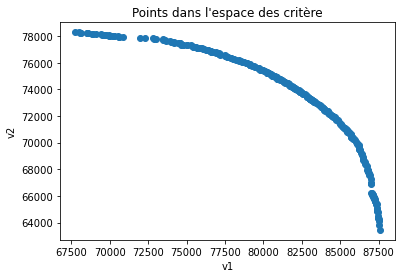

In [9]:
plt.scatter(*points.T)
plt.title("Points dans l'espace des critère")
plt.xlabel("v1")
plt.ylabel("v2")
plt.show()

In [7]:
np.savetxt('./sol/I2dim.sol', points)

In [15]:
points = np.loadtxt('./sol/I2dim.sol')
points = points.astype(int)

## Procedure II

In [19]:
class Model():
	def __init__(self, dim):
		self.model = None
		self.dim = dim

	# OWA aggregator model
	def init_owa_model(self):
		self.model = gp.Model('ModelEU')
		self.model.Params.LogToConsole = 0
		m = self.model
		w = np.array([m.addVar() for _ in range(self.dim)])
		self.w = w
		for i in range(self.dim-1):
			m.addConstr(w[i]-w[i+1]>=0, f'c{i+1}')
		m.addConstr(sum(w) == 1)

	def update_owa(self, a,b):
		a, b = np.sort(a), np.sort(b)
		#self.model.Params.LogToConsole = 1
		#self.model.display()
		self.model.addConstr(sum((a-b)*self.w) >= 0)
		self.model.update()
		#self.model.display()

	# Optimize with the OWA function
	def optimize(self, a, b=None):
		if b is None: b = np.zeros(self.dim)
		a, b = np.asarray(a), np.asarray(b)
		a.sort()
		b.sort()
		self.model.setObjective(sum(self.w*(a-b)), GRB.MAXIMIZE)
		self.model.update()
		self.model.optimize()
		return self.model.ObjVal

	def CSS(self, X):
		PMR = [[self.optimize(y,x) for y in X] for x in X]
		i = np.argmin(np.max(PMR,1))
		j = np.argmax(PMR[i])
		return (X[i],X[j])

In [20]:
p = 2
alpha = np.random.dirichlet(np.ones(p),size=1)[0]
alpha.sort()
alpha = alpha[::-1]
print('alpha: ', *alpha)

owa_value = [owa(y, alpha) for y in points]
opt = points[np.argmax(owa_value)]
opt

alpha:  0.6525787077519826 0.34742129224801754


array([75911, 79095])

In [21]:
model = Model(dim=p)
model.init_owa_model()

o1, o2 = model.CSS(points)
iteration = 1
for _ in range(100):
    if np.array_equal(o1, o2): break
    if owa(o1,alpha) >= owa(o2, alpha):
        model.update_owa(o1,o2)
    else:
        model.update_owa(o2,o1)
    print(f'{iteration = }')
    o1, o2 = model.CSS(points)
    print(o1, o2)
    iteration += 1

iteration = 1
[76376 77880] [74274 81869]
iteration = 2
[74897 80899] [74274 81869]
iteration = 3
[75306 80211] [74471 81589]
iteration = 4
[75306 80211] [75911 79095]
iteration = 5
[75911 79095] [75626 79621]
iteration = 6
[75911 79095] [75911 79095]
